# NLP Distasters Tweets Project

Now days Twitter is an important channel of communication. Thousands of people use it every day to share things from random thoughts, memes, scientific threads to messages about disasters and emergencies happening in real-time somewhere in the world.

Being able to separate these emergency tweets from the noise is going to be our main goal. We will be dealing with a dataset containing 7613 labeled tweets.

We will explore different machine learning models and tokenization/vectorization strategies to find the one that perform the best. Our current best method shows an **F1-score of 0.80723** on the hidden test set provided by Kaggle.

-----
Author: Santiago Víquez Segura

I'm constantly sharing stuff about data science and machine learning on [Twitter](https://twitter.com/santiviquez). Follow me if you want to join me and keep learning in public :)

# Importing all dependencies

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.compose import ColumnTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from xgboost import XGBClassifier
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import re
import string

# Reading files

During all the analysis and modeling we will only use the **train.csv** dataset. We will use the **test.csv** only once to make predictions to submit to the [kaggle competition](http://https://www.kaggle.com/c/nlp-getting-started)

In [ ]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

# Quick view of the data

One important thing to notice is that the target column is not 100% balanced. This is something that we will take into account when choosing a validation strategy and a validation error metric.

In [ ]:
train.target.value_counts(normalize=True)

In [ ]:
print(f"Shape of the training dataset {train.shape}")

Besides the text data we have keyword and location columns. Although it contains some null values

In [ ]:
train.head()

In [ ]:
print(f"Proportion of NaN keyword values: {train.keyword.isna().sum() / len(train)}")
print(f"Proportion of NaN location values: {train.location.isna().sum() / len(train)}")

The keyword feature seems like it could be usefull. It contains some NaN values but not that much to be imputed and still add some value to the models.

## Tweet examples

Let's take a look at some disaster and non disaster tweets.

In [ ]:
# Disaster example
disaster = train[train.target == 1]['text'].iloc[3]

# Not a disaster example
not_disaster = train[train.target == 0]['text'].iloc[3]

print(f"Disaster tweet example: {disaster}")
print(f"NOT a disaster tweet example: {not_disaster}")

# "Global" variables

In [ ]:
SEED = 42
FOLDS = 5 # number of folds that we will create in the next steps
np.random.seed(SEED)

# Data Cleaning
Let's check if our data contains urls, hashtags or weird non important symbols that we would like to remove before our analysis

## Cleaning URLs

In [ ]:
# Looking for urls
train[train.text.str.contains("https.")].head()

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

train['text'] = train['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

## Cleaning Hashtag symbols

In [ ]:
# Looking for hashtag symbols
train[train.text.str.contains("#")].head()

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

## Removing whitespaces

In [ ]:
train['text']=train['text'].str.replace('   ', ' ')
train['text']=train['text'].str.replace('     ', ' ')
train['text']=train['text'].str.replace('\xa0 \xa0 \xa0', ' ')
train['text']=train['text'].str.replace('  ', ' ')
train['text']=train['text'].str.replace('—', ' ')
train['text']=train['text'].str.replace('–', ' ')

test['text']=test['text'].str.replace('   ', ' ')
test['text']=test['text'].str.replace('     ', ' ')
test['text']=test['text'].str.replace('\xa0 \xa0 \xa0', ' ')
test['text']=test['text'].str.replace('  ', ' ')
test['text']=test['text'].str.replace('—', ' ')
test['text']=test['text'].str.replace('–', ' ')

## Working with NaN values

We will probably use the **keyword** column but it has some NaN values. But we don't want to delete the examples only because the keyword column has a NaN. So we'll fill the NaN fields with a random string. As a way to "encode" it.

In [ ]:
train.fillna("99999", inplace=True)
test.fillna("99999", inplace=True)

# Cross validation - Stratified Kfold
An important part of building a robust machine learning model is having a robust validation strategy. Since our target is not balanced we'll use stratified kfold to split the data. This way we make sure that each fold has the same 1/0 distribution.

In [ ]:
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Evaluation Function
Again, since we are dealing with a binary classification problem and the target is not balanced we choose F1-score as our validation metric. During each experiment we will try to get a better F1 validation score.

In [ ]:
def evaluate_model(y_true, y_pred):    
    # calculate f1 score
    f1 = f1_score(y_true, y_pred)    
    print(f"Validation F1: {f1}")
    print("")
    return f1

# Helper functions

## Model scores

The `get_model_scores` function gets a:
* X: training test
* y: target
* pipeline: pipeline with the preprossing and estimator
* cv: cross-validation strategy

And computes the cross validatidated F1 score for each fold K in the cv.

The `print_score_summary` function gets a list of **f1-scores** and return a formated print with the score for each fold

In [ ]:
def get_model_scores(X, y, pipeline, cv):
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return scores

def print_score_summary(scores):
    for fold, score in enumerate(scores):
        print(f"Fold {fold}:")
        print(f"F1 validation score: {score}")
        print("")
    
    print(f"Average F1 validation: {np.mean(scores)}")

## Plot Learning Curves

The `plot_learning_curve` function gets a:
* X: training test
* y: target
* estimator: can be an estimator or pipeline with the preprossesing
* cv: cross-validation strategy
* title: string with the title of the plot

And plots the train and validation curves.

In [ ]:
def plot_learning_curve(estimator, X, y, cv, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator,
                                                             X,
                                                             y,
                                                             scoring="f1",
                                                             cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(valid_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(valid_scores, axis=1)

    fig, ax = plt.subplots()
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, val_scores_mean, "o-", color="g", label="Cross-validation score")
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.set_ylim(0.0, 1.01)
    ax.legend(loc="best")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("F1-score")
    ax.set_title(f"{title}")
    plt.show()

# Experiments

This is where the fun part beggings. We will explore 7 different experiments. Each one tries to get a better F1 validation score than the last one.

At the end we will choose our three top performing models and make and esamble.

## Experiment 1: Dummy Baseline
Let's train a logistic regression learner using ONLY the **keyword** column. The purpuse of this model is to build a reference or baseline model. Any other more complex model should be better than this.

In [ ]:
# create a list to append the steps of the preprossesing pipeline
steps_baseline = list()
steps_baseline.append(('encoder', OneHotEncoder(handle_unknown='ignore')))
steps_baseline.append(('model', LogisticRegression(solver='liblinear')))

# create the pipeline
pipeline_baseline = Pipeline(steps=steps_baseline)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train[['keyword']],
                          y=train['target'],
                          pipeline=pipeline_baseline,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_baseline,
                    X=train[['keyword']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

We got a nice intial result. Using just the column **keyword** we got a better than random! An **F1 score of: 0.672**

Let's see if we can get a better result by using the **text** column and TF-IDF vectorization.

## Experiment 2: Logistic Regression and TF-IDF

TF is term frequencies and IDF is inverse document frequency.

In [ ]:
# create a list to append the steps of the preprossesing pipeline
steps_tfidf = list()
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
steps_tfidf.append(('tf-idf', vectorizer))
steps_tfidf.append(('model', LogisticRegression(solver='liblinear')))

# create the pipeline
pipeline_tfidf = Pipeline(steps=steps_tfidf)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train.text,
                          y=train['target'],
                          pipeline=pipeline_tfidf,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_tfidf,
                    X=train.text,
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Logistic Regression with TF-IDF")

print_score_summary(scores)

Nice! We got a decent result for every fold. An average **F1 score of 0.753**. And an improvement from our previuos dummy model. Looks like we are on the right track!

For the next experiment let's try CountVectorizer instead TF-IDF.

## Experiment 3: LogisticRegression + CountVectorizer
CountVectorizer will transform the text data into numerical features. Each word in the tweets will be transform to a number. This number will be the amount of times it appears in a single tweet.

Using this simple method we are assuming that words contained in each tweet is a good indicator weather the tweet is about a disaster or not.

In [ ]:
# create a list to append the steps of the preprossesing pipeline
steps_countvec = list()
vectorizer = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
steps_countvec.append(('count-vectorizer', vectorizer))
steps_countvec.append(('model', LogisticRegression(solver='liblinear')))

# create the pipeline
pipeline_countvec = Pipeline(steps=steps_countvec)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train.text,
                          y=train['target'],
                          pipeline=pipeline_countvec,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_countvec,
                    X=train.text,
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Logistic Regression with CountVectorizer")

print_score_summary(scores)

We got almost the same result that with TF-IDF. Although if we look at the learning curve it seems that the model is overfitting.

Let's try adding a higher regularization parameter and increasing the number of iterations.

In [ ]:
# create a list to append the steps of the preprossesing pipeline
steps_countvec = list()
vectorizer = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
steps_countvec.append(('count-vectorizer', vectorizer))
steps_countvec.append(('model', LogisticRegression(solver='saga',
                                                   C=0.3, # inverse of the regularization parameter
                                                   fit_intercept=False,
                                                   max_iter=800,
                                                   penalty="l2")))

# create the pipeline
pipeline_countvec = Pipeline(steps=steps_countvec)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train.text,
                          y=train['target'],
                          pipeline=pipeline_countvec,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_countvec,
                    X=train.text,
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Logistic Regression with CountVectorizer")

print_score_summary(scores)

It worked! We reduced a bit the gap between the training and the validation curves. And now we have a new benchmark to beat! F1-score of **0.755**

We are moving on the right direction with this logistic regression model. Let's try adding lemmatization to the text data and incorporating the **keyword** column as a feature

## Experiment 4: LogisticRegression CountVectorizer + Lemmatization + Keyword column

So far in the last 3 experiments we have been using only the text data. Let's see if we see any benefit when adding the keyword column and some lemmatization to the text data.

In [ ]:
# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

In [ ]:
# create a list to append the steps of the preprossesing pipeline
steps_exp_4 = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])
steps_exp_4.append(('features', col_transformations))
steps_exp_4.append(('model', LogisticRegression(solver='saga',
                                          C=0.3,
                                          fit_intercept=False,
                                          max_iter=800,
                                          penalty="l2",
                                          random_state=SEED)))

pipeline_exp_4 = Pipeline(steps=steps_exp_4)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_exp_4,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_exp_4,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Logistic Regression with CountVectorizer and Lemmatization")

print_score_summary(scores)

Another improvement! Indeed adding lemmatization and the keyword feature helped! And we found a new benchmark. We went from an average F1: 0.755 to an **average F1: 0.764**

Let's explore other model arquitectures with this same preprocesssing pipeline that we have built so far.

## Experiment 5: LinearSVC + CountVectorizer + Lemmatization + Keyword column

In [ ]:
# create a list to append the steps of the preprossesing pipeline
steps_exp_5 = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])
steps_exp_5.append(('features', col_transformations))
steps_exp_5.append(('model', svm.LinearSVC(penalty="l2",
                                     C=0.02,
                                     random_state=SEED)))

pipeline_exp_5 = Pipeline(steps=steps_exp_5)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_exp_5,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_exp_5,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - LinearSVC with CountVectorizer and Lemmatization")

print_score_summary(scores)

We got a good result, however the logistic regressor is still performing better.

For the next step lets try a model that is quite popular in the Machine Learning community. XGBoost!

## Experiment 6: XGBoost + CountVectorizer + Lemmatization + Keyword column

In [ ]:
# create a list to append the steps of the preprossesing pipeline
steps_exp_6 = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])
steps_exp_6.append(('features', col_transformations))
steps_exp_6.append(('model', XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=SEED)))

pipeline_exp_6 = Pipeline(steps=steps_exp_6)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_exp_6,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_exp_6,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - XGBoost with CountVectorizer and Lemmatization")

print_score_summary(scores)

Look like the logistic regression model is still our benchmark.

## Experiment 7: Stacking classifiers

In this experiment we will try to see if stacking our 3 main classifiers:
* Logistics Regression
* LinearSVC
* XGBoost

Outperforms our current benchmark: **F1: 0.764** from experiment 4.


In [ ]:
estimators = [
    ('lgr', LogisticRegression(solver='saga',
                               C=0.3,
                               fit_intercept=False,
                               max_iter=800,
                               penalty="l2",
                               random_state=SEED)),
    
    ('svc', svm.LinearSVC(penalty="l2",
                          C=0.02,
                          random_state=SEED)),
    
    ('xgboost', XGBClassifier(eval_metric="logloss",
                              use_label_encoder=False,
                              random_state=SEED))
]


# create a list to append the steps of the preprossesing pipeline
steps_ensamble = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])
steps_ensamble.append(('features', col_transformations))
steps_ensamble.append(('stacking', StackingClassifier(estimators, cv=CV)))

pipeline_ensamble = Pipeline(steps=steps_ensamble)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_ensamble,
                          cv=CV)

print_score_summary(scores)

Niiice! We see a small improvement but still an improvement. We have a new benchmark of **F1-score: 0.765**

# Final Predictions

Let's use this stacked model to make the final predictions on the test set. And submit them to Kaggle.

In [ ]:
pipeline_ensamble.fit(train[['keyword','text']], train['target'])
preds = pipeline_ensamble.predict(test[['keyword', 'text']])

submission = sample_submission.copy()
submission.target = preds

submission.to_csv('stacking_ensameble_lgr_svc_xgboost.csv', index=False)
submission.target.value_counts()

We got great results! An F1 score of 0.80723 on the test set. Even better than the results that we have been having on the validation folds. This is where having a good validation strategy pays off.

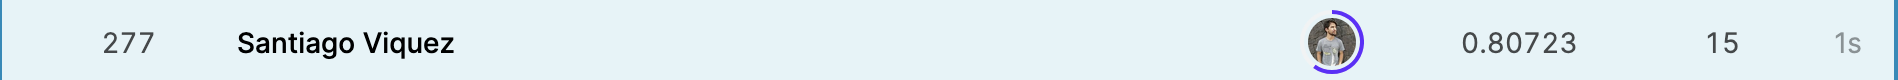

I'm constantly sharing stuff about data science and machine learning on [Twitter](https://twitter.com/santiviquez). Follow me if you want to join me and keep learning in public :)